Dropped columns: ['CVrmsAvg_Volts', 'CVTHDRssAvg_Volts']
Columns remaining after drops: ['AVrmsAvg_Volts', 'BVrmsAvg_Volts', 'AIrmsAvg_Amps', 'BIrmsAvg_Amps', 'CIrmsAvg_Amps', 'AVTHDRssAvg_Volts', 'BVTHDRssAvg_Volts', 'TOTDemand_kWh_hValue_kWh_h']

Number of anomalous rows identified (AVrmsAvg_Volts < 100V): 13
Shape of DataFrame before removing anomalies: (2323, 8)
Shape of DataFrame after removing anomalies: (2310, 8)

DataFrame info after cleaning and feature engineering:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2310 entries, 2025-04-30 09:30:00 to 2025-05-08 11:00:00
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   AVrmsAvg_Volts              2310 non-null   float64
 1   BVrmsAvg_Volts              2310 non-null   float64
 2   AIrmsAvg_Amps               2310 non-null   float64
 3   BIrmsAvg_Amps               2310 non-null   float64
 4   CIrmsAvg_Amps               23

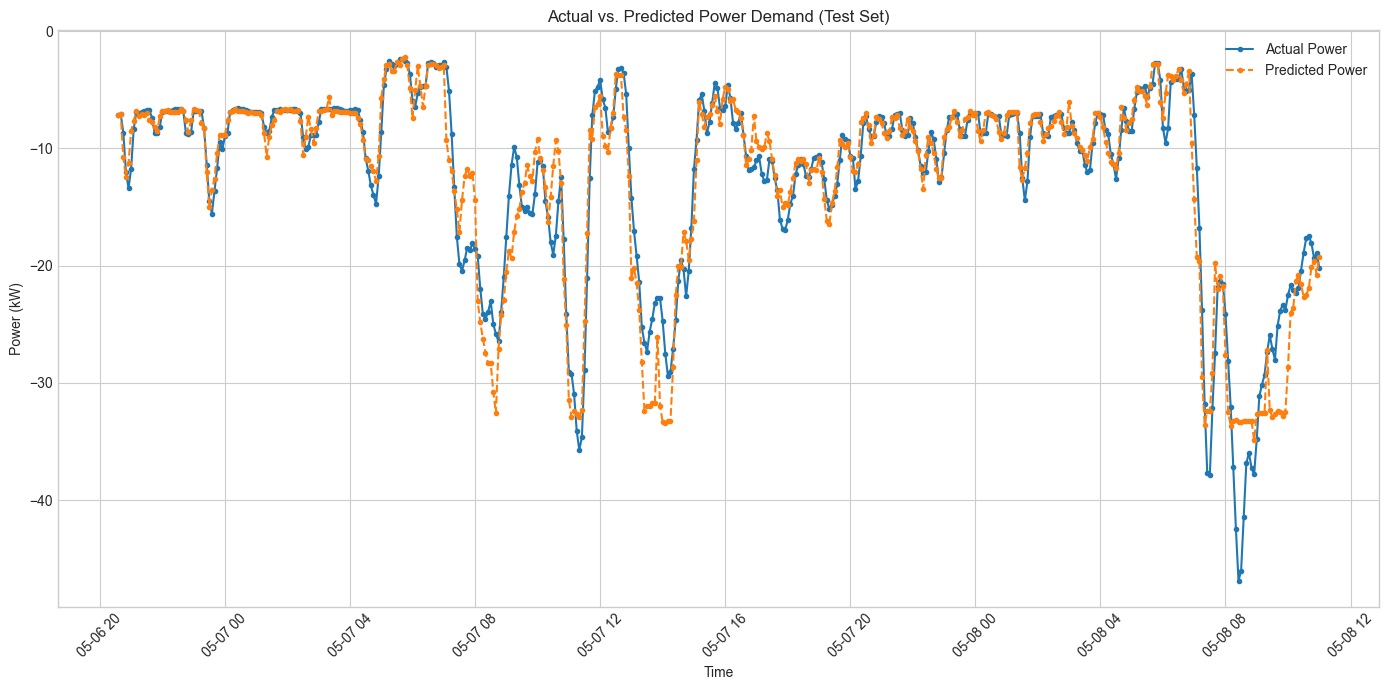

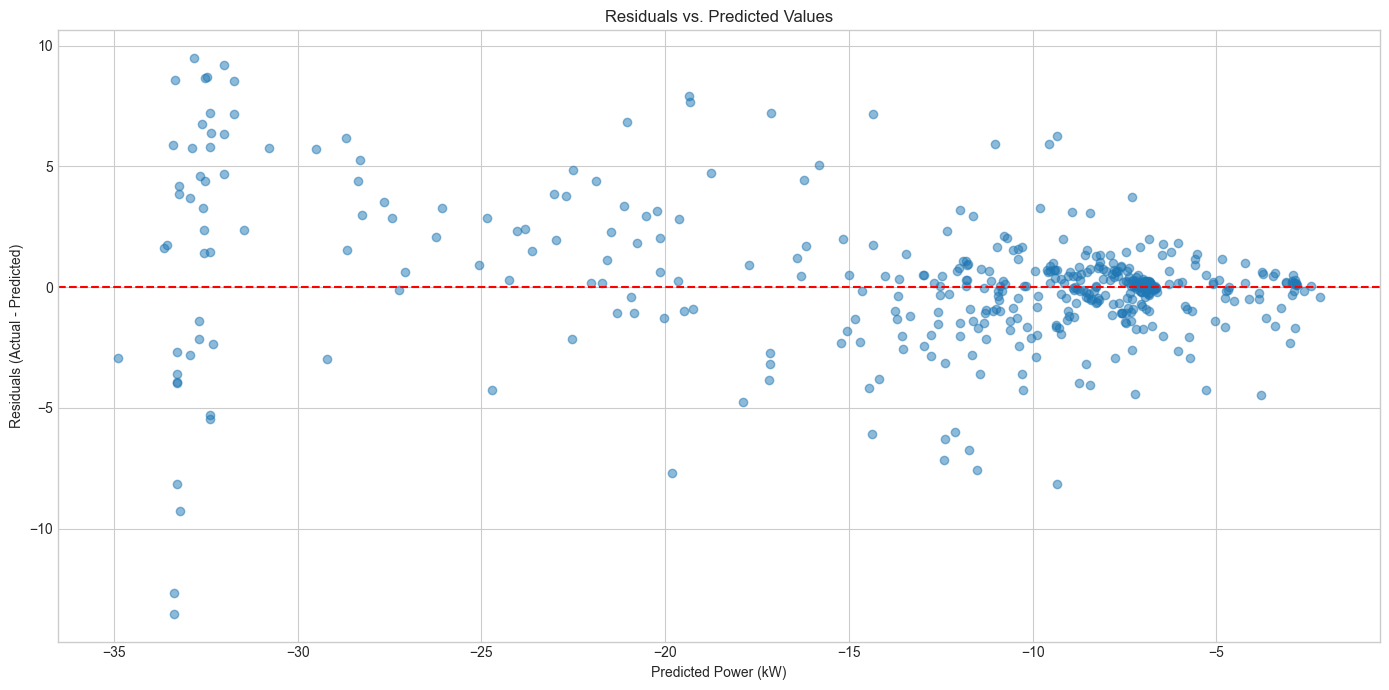

C:\Users\hp\AppData\Local\Temp\ipykernel_8284\1443320707.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importances_df.head(15), palette='viridis') # Top 15 features


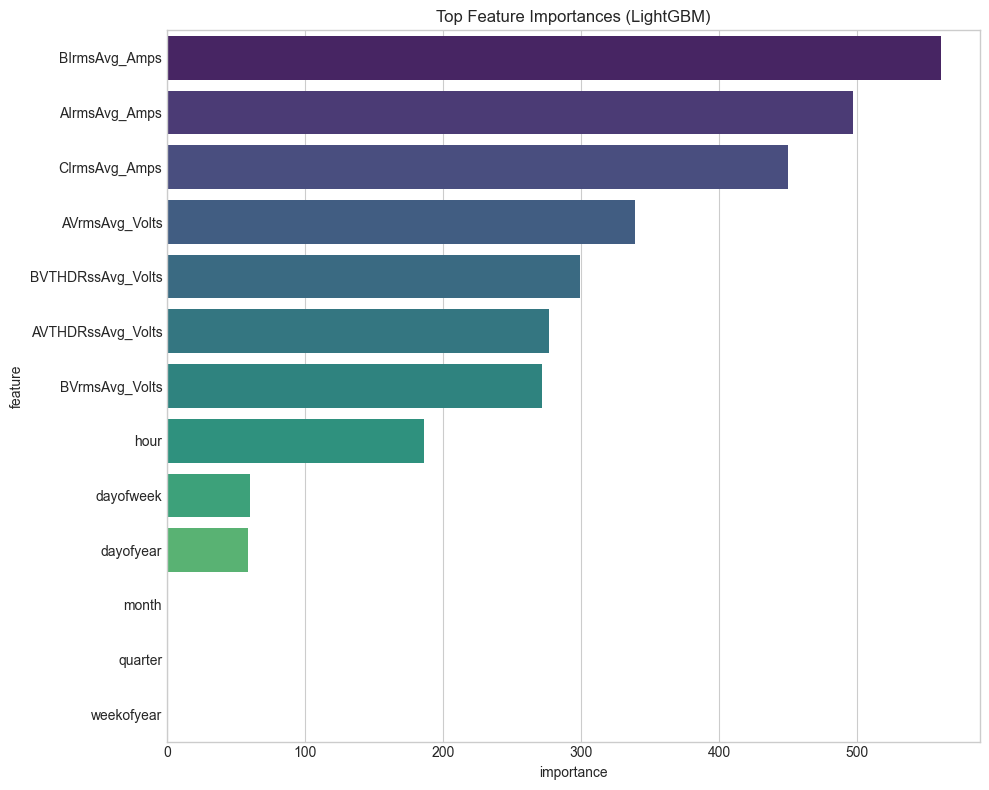


--- Pipeline execution complete (simulated) ---


In [7]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split # Though we'll do a chronological split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

def run_modelling_pipeline_with_viz():
    # --- Load and Prepare Data ---
    file_path = r"C:\Users\hp\Desktop\REG108S\Project\MeasuredData_Filled.csv" # Ensure this file is accessible
    
    df = pd.read_csv(file_path)
    
    df['X-Data'] = pd.to_datetime(df['X-Data'])
    df.set_index('X-Data', inplace=True)

    original_columns = df.columns.tolist()
    new_columns = [col.replace('[', '_').replace(']', '').replace('(', '_').replace(')', '').replace('/', '_') for col in original_columns]
    df.columns = new_columns

    columns_to_drop = ['CVrmsAvg_Volts', 'CVTHDRssAvg_Volts']
    existing_columns_to_drop = [col for col in columns_to_drop if col in df.columns]
    if existing_columns_to_drop:
        df.drop(columns=existing_columns_to_drop, inplace=True)
        print(f"Dropped columns: {existing_columns_to_drop}")
    else:
        print(f"Warning: Columns to drop not found: {columns_to_drop}")
    
    print(f"Columns remaining after drops: {df.columns.tolist()}")

    anomalous_rows_mask = (df['AVrmsAvg_Volts'] < 100)
    num_anomalous_rows_found = anomalous_rows_mask.sum()
    print(f"\nNumber of anomalous rows identified (AVrmsAvg_Volts < 100V): {num_anomalous_rows_found}")
    
    df_cleaned = df[~anomalous_rows_mask].copy()

    print(f"Shape of DataFrame before removing anomalies: {df.shape}")
    print(f"Shape of DataFrame after removing anomalies: {df_cleaned.shape}")

    if df_cleaned.empty:
        print("Error: DataFrame is empty after removing anomalous rows. Cannot proceed.")
        return None, None, None

    # Feature Engineering: Time-based features
    df_cleaned['hour'] = df_cleaned.index.hour
    df_cleaned['dayofweek'] = df_cleaned.index.dayofweek
    df_cleaned['dayofyear'] = df_cleaned.index.dayofyear
    df_cleaned['month'] = df_cleaned.index.month
    df_cleaned['quarter'] = df_cleaned.index.quarter
    df_cleaned['weekofyear'] = df_cleaned.index.isocalendar().week.astype(int)
    
    print("\nDataFrame info after cleaning and feature engineering:")
    df_cleaned.info()
    # print("\nFirst 5 rows of the cleaned and engineered DataFrame:")
    # print(df_cleaned.head())

    # --- Model Training and Evaluation ---
    target_variable = 'TOTDemand_kWh_hValue_kWh_h'
    
    if target_variable not in df_cleaned.columns:
        print(f"Error: Target variable '{target_variable}' not found. Available columns: {df_cleaned.columns.tolist()}")
        return None, None, None

    X = df_cleaned.drop(columns=[target_variable])
    y = df_cleaned[target_variable]

    # Chronological split
    test_size = 0.2
    if len(X) < 10: # Increased minimum for a more meaningful split for plotting too
        print("Warning: Not enough data for a robust train/test split and visualization. Consider acquiring more data.")
        X_train, X_test = X, X
        y_train, y_test = y, y
    else:
        split_index = int(len(X) * (1 - test_size))
        X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
        y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

    print(f"\nX_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

    if X_train.empty or X_test.empty:
        print("Error: Training or testing set is empty after split. Cannot proceed.")
        return None, None, None

    lgbm = lgb.LGBMRegressor(random_state=42, verbosity=-1)
    lgbm.fit(X_train, y_train)
    y_pred = lgbm.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = -1.0 
    if len(y_test) >= 2:
        r2 = r2_score(y_test, y_pred)

    print("\nModel Evaluation Metrics:")
    print(f"  Mean Absolute Error (MAE): {mae:.4f}")
    print(f"  Mean Squared Error (MSE): {mse:.4f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"  R-squared (R²): {r2:.4f}")

    feature_importances_df = pd.DataFrame({'feature': X_train.columns, 'importance': lgbm.feature_importances_})
    feature_importances_df = feature_importances_df.sort_values(by='importance', ascending=False)
    print("\nFeature Importances:")
    print(feature_importances_df.head(10)) # Print top 10

    test_results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}, index=y_test.index)
    print("\nFirst 5 actual vs predicted values:")
    print(test_results_df.head())
    
    # --- Visualization ---
    plt.style.use('seaborn-v0_8-whitegrid') # Using a seaborn style

    # 1. Actual vs. Predicted Plot
    plt.figure(figsize=(14, 7))
    plt.plot(test_results_df.index, test_results_df['Actual'], label='Actual Power', marker='.', linestyle='-')
    plt.plot(test_results_df.index, test_results_df['Predicted'], label='Predicted Power', marker='.', linestyle='--')
    plt.title('Actual vs. Predicted Power Demand (Test Set)')
    plt.xlabel('Time')
    plt.ylabel('Power (kW)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # 2. Residuals Plot
    residuals = test_results_df['Actual'] - test_results_df['Predicted']
    plt.figure(figsize=(14, 7))
    plt.scatter(test_results_df['Predicted'], residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.title('Residuals vs. Predicted Values')
    plt.xlabel('Predicted Power (kW)')
    plt.ylabel('Residuals (Actual - Predicted)')
    plt.tight_layout()
    plt.show()

    # 3. Feature Importance Plot
    if not feature_importances_df.empty:
        plt.figure(figsize=(10, 8))
        sns.barplot(x='importance', y='feature', data=feature_importances_df.head(15), palette='viridis') # Top 15 features
        plt.title('Top Feature Importances (LightGBM)')
        plt.tight_layout()
        plt.show()
    
    return df_cleaned, lgbm, test_results_df

if __name__ == '__main__':
    df_processed, model, test_results = run_modelling_pipeline_with_viz()
    
    if df_processed is not None:
        print("\n--- Pipeline execution complete (simulated) ---")